# MIT-BIH ECG Dataset Preprocessing Source Code

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install wfdb

     |████████████████████████████████| 102kB 2.9MB/s 
     |████████████████████████████████| 163kB 9.0MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=4e491642cc6dde188ee5c7529cfadddd79831a618b863acc0b022ee5f5cc5a54
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


In [3]:
import os
import numpy as np
import wfdb
import pywt
import matplotlib.pyplot as plt

# download MIT-BIT dataset
if not os.path.exists(os.path.join(root_path, 'mitdb')):
    wfdb.dl_database('mitdb', os.path.join(root_path, 'mitdb'))
else:
    print('You already have the MIT-BIH data.')

You already have the MIT-BIH data.


In [4]:
# exclude patients [102, 104, 107, 114, 217] due to poor signal quality
rm_patient = [102, 104, 107, 114, 217]  # patients to remove
files = os.listdir(os.path.join(root_path, 'mitdb'))
patients = [int(f[0:-4]) for f in files if f[-4:] != 'hdf5']
patients = list(set(patients))
patients.sort()  # list of all patients
for p in rm_patient:
    patients.remove(p)
print(patients)

[100, 101, 103, 105, 106, 108, 109, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 219, 220, 221, 222, 223, 228, 230, 231, 232, 233, 234]


In [0]:
def is_valid_sample(left, cur, right, interval, siglen):
    left_val = cur - interval >= 0 and cur - interval >= left
    right_val = cur + interval <= siglen - 1 and cur + interval <= right
    return left_val and right_val

def denoise(signal):
    thr = 0.005 * np.sqrt(2 * np.log2(len(signal)))
    c = pywt.wavedec(signal, 'bior4.4')
    thr_func = lambda x : pywt.threshold(x, thr, 'soft')
    nc = list(map(thr_func, c))
    return pywt.waverec(nc, 'bior4.4')

In [0]:
interval = 100  # length to slice from R-peak

# make [N, L, R, A, V] classified data
x = []
y = []
label_list = ['N', 'L', 'R', 'A', 'V']
for p in patients:
    samp = wfdb.rdsamp(os.path.join(root_path, 'mitdb', str(p)))
    signal = np.array(samp[0][:, 0])  # second lead beats of a patient
    signal = (signal - min(signal)) / (max(signal) - min(signal))  # normalize
    ann = wfdb.rdann(os.path.join(root_path, 'mitdb', str(p)), 'atr')  # annotations of each beat
    r_peaks = ann.sample[1:-1]  # get R-peaks of each beat
    labels = ann.symbol[1:-1]  # get labels of each beat
    for i in range(1, len(r_peaks) - 1):
        if is_valid_sample(r_peaks[i-1], r_peaks[i], r_peaks[i+1], interval, len(signal)) and labels[i] in label_list:
            beat = signal[r_peaks[i] - interval:r_peaks[i] + interval + 1]
            assert len(beat) == 2 * interval + 1
            x.append(beat)
            y.append(label_list.index(labels[i]))

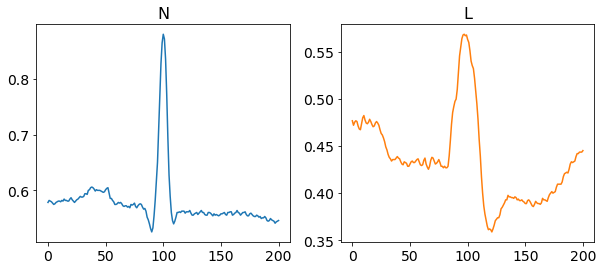

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4)) # 16,5
for i in range(5):
    ax[i].set_title(label_list[i], size=16)
    idx = y.index(i)
    beat = x[idx]
    ax[i].tick_params(labelsize=14)
    ax[i].plot(beat, color='C'+str(i))
# fig.savefig(os.path.join(root_path, 'img', 'preprocess_before_2.pdf'), bbox_inches="tight")

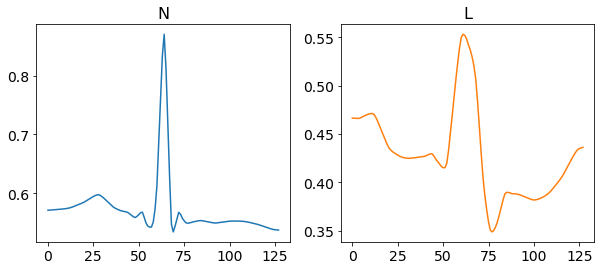

In [8]:
from scipy.signal import resample

# downsample the signal
sample_size = 128
for i in range(len(x)):
    # x[i] = (x[i] - min(x[i])) / (max(x[i]) - min(x[i]))  # normalize
    x[i] = resample(x[i], sample_size)
    x[i] = denoise(x[i])  # denoise

fig, ax = plt.subplots(1, 2, figsize=(10,4)) # 16,5
for i in range(5):
    ax[i].set_title(label_list[i], size=16) # 18
    idx = y.index(i)
    beat = x[idx]
    ax[i].tick_params(labelsize=14) # 16
    ax[i].plot(beat, color='C'+str(i))
# fig.savefig(os.path.join(root_path, 'img', 'preprocess_after_2.pdf'), bbox_inches="tight")

In [9]:
from collections import Counter

x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)
print(Counter(y))

(96049, 128)
(96049,)
Counter({0: 71732, 1: 8036, 2: 7231, 4: 6559, 3: 2491})


In [10]:
# make it balanced
sample_list = [[], [], [], [], []]
for i in range(len(x)):
    sample_list[y[i]].append(x[i])
sample_list = np.array(sample_list)

np.random.seed(2019)
num_to_sample = [6000, 6000, 6000, 2490, 6000]  # from [N, L, R, A, V]
for i in range(len(num_to_sample)):
    idx = np.random.choice(len(sample_list[i]), num_to_sample[i])
    sample_list[i] = np.array(sample_list[i])[idx]
    print(sample_list[i].shape)

(6000, 128)
(6000, 128)
(6000, 128)
(2490, 128)
(6000, 128)


In [11]:
x_train = None
y_train = None
x_test = None
y_test = None

# make train and test set
for i in range(len(num_to_sample)):
    if x_train is not None:
        x_train = np.concatenate((x_train, sample_list[i][:int(num_to_sample[i] / 2)]))
        y_train += [i] * int(num_to_sample[i] / 2)
        x_test = np.concatenate((x_test, sample_list[i][int(num_to_sample[i] / 2):]))
        y_test += [i] * int(num_to_sample[i] / 2)
    else:
        x_train = sample_list[i][:int(num_to_sample[i] / 2)]
        y_train = [i] * int(num_to_sample[i] / 2)
        x_test = sample_list[i][int(num_to_sample[i] / 2):]
        y_test = [i] * int(num_to_sample[i] / 2)
y_train = np.array(y_train)
y_test = np.array(y_test)

# shuffle train and test set
idx = np.arange(len(x_train))
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]
np.random.shuffle(idx)
x_test = x_test[idx]
y_test = y_test[idx]

print(x_train.shape)
print(y_train.shape)
print(Counter(y_train))
print(x_test.shape)
print(y_test.shape)
print(Counter(y_test))

(13245, 128)
(13245,)
Counter({2: 3000, 4: 3000, 1: 3000, 0: 3000, 3: 1245})
(13245, 128)
(13245,)
Counter({1: 3000, 0: 3000, 2: 3000, 4: 3000, 3: 1245})


In [12]:
# create num_channels dimension
x = np.expand_dims(x, axis=1)
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)
print(x.shape)
print(x_train.shape)
print(x_test.shape)

(96049, 1, 128)
(13245, 1, 128)
(13245, 1, 128)


In [13]:
import h5py

# save to hdf5 file
with h5py.File(os.path.join(root_path, 'mitdb', 'all_ecg.hdf5'), 'w') as hdf:
    hdf['x'] = x[:]
    hdf['y'] = y[:]
    print('All data saved to all_ecg.hdf5')
with h5py.File(os.path.join(root_path, 'mitdb', 'train_ecg.hdf5'), 'w') as hdf:
    hdf['x_train'] = x_train[:]
    hdf['y_train'] = y_train[:]
    print('Train data saved to train_ecg.hdf5')
with h5py.File(os.path.join(root_path, 'mitdb', 'test_ecg.hdf5'), 'w') as hdf:
    hdf['x_test'] = x_test[:]
    hdf['y_test'] = y_test[:]
    print('Test data saved to test_ecg.hdf5')

All data saved to all_ecg.hdf5
Train data saved to train_ecg.hdf5
Test data saved to test_ecg.hdf5
